In [63]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [197]:
file = "Entrenamieto_ECI_2020.csv"
data = pd.read_csv(file)
data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
data = data[(data.Stage == "Closed Won") | (data.Stage == "Closed Lost")]
data.Stage = data.Stage.replace({"Closed Won": 1, "Closed Lost": 0})

In [287]:
clear = ["Opportunity_Name","ID","Last_Activity", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "ASP_converted_Currency", "Product_Name", 
         "Delivery_Year", "Month", "TRF", "Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", 
         "Price", "ASP_Currency", "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type",
         "Product_Family", "Account_Name"]
dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date", "Last_Activity", "Actual_Delivery_Date"]
target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [288]:
def preprocess(data):
    
    # elimino caracteres prohibidos
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
            
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    # Contacts: la cantidad de negociaciones registradas
    # Delivery_difference: la cantidad de dias entre las fechas planeadas final e inicial de delivery
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days    
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    data["Has_Quote"] = ~(data.Offer_Duration.isna())
    data["Same_Owner"] = (data.Opportunity_Owner == data.Account_Owner) & (data.Opportunity_Owner == data.Last_Modified_By)
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"  
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort = False)["Account_Name"].transform("count")
    data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (pd.to_datetime(data.Last_Modified_Date) - pd.to_datetime(data.Quote_Expiry_Date)).dt.days
     
    # limpio columnas
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype("category")
    
    data = data.drop(clear + dates, axis = 1)       
    
    return (data)

In [326]:
df = preprocess(data)

In [327]:
x_train, x_test, y_train, y_test = train_test_split(df, df.Stage, test_size = 0.3, random_state = 0, stratify = df.Stage)
categorical = [x for x in df.drop(target, axis=1).select_dtypes('category').columns if x != 'Stage'] + ["TRF_Cat"]
#categorical = [x for x in cat_vars if x in df.columns]
train_data = lgb.Dataset(data = x_train.drop(target, axis = 1), label = x_train.Stage, categorical_feature = categorical)
test_data =  lgb.Dataset(data = x_test.drop(target, axis = 1), label = x_test.Stage)

parameters = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 50,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.6,
    'bagging_freq': 30,
    'learning_rate': 0.015,
    'max_bin': 400,
    'verbose': 0
}

model1 = lgb.train(parameters, train_data, valid_sets = test_data, num_boost_round = 5000, early_stopping_rounds = 500)

[1]	valid_0's binary_logloss: 0.676746
Training until validation scores don't improve for 500 rounds
[2]	valid_0's binary_logloss: 0.66888
[3]	valid_0's binary_logloss: 0.661646
[4]	valid_0's binary_logloss: 0.654438
[5]	valid_0's binary_logloss: 0.642422
[6]	valid_0's binary_logloss: 0.637213
[7]	valid_0's binary_logloss: 0.625664
[8]	valid_0's binary_logloss: 0.619317
[9]	valid_0's binary_logloss: 0.612915
[10]	valid_0's binary_logloss: 0.606617
[11]	valid_0's binary_logloss: 0.600712
[12]	valid_0's binary_logloss: 0.595351
[13]	valid_0's binary_logloss: 0.589815
[14]	valid_0's binary_logloss: 0.579544
[15]	valid_0's binary_logloss: 0.573964
[16]	valid_0's binary_logloss: 0.569109
[17]	valid_0's binary_logloss: 0.563732
[18]	valid_0's binary_logloss: 0.558999
[19]	valid_0's binary_logloss: 0.549507
[20]	valid_0's binary_logloss: 0.544648
[21]	valid_0's binary_logloss: 0.535567
[22]	valid_0's binary_logloss: 0.530821
[23]	valid_0's binary_logloss: 0.522005
[24]	valid_0's binary_loglos

[217]	valid_0's binary_logloss: 0.133871
[218]	valid_0's binary_logloss: 0.132973
[219]	valid_0's binary_logloss: 0.13273
[220]	valid_0's binary_logloss: 0.132521
[221]	valid_0's binary_logloss: 0.131615
[222]	valid_0's binary_logloss: 0.131373
[223]	valid_0's binary_logloss: 0.131168
[224]	valid_0's binary_logloss: 0.130893
[225]	valid_0's binary_logloss: 0.130684
[226]	valid_0's binary_logloss: 0.129789
[227]	valid_0's binary_logloss: 0.129538
[228]	valid_0's binary_logloss: 0.12931
[229]	valid_0's binary_logloss: 0.129036
[230]	valid_0's binary_logloss: 0.128268
[231]	valid_0's binary_logloss: 0.127392
[232]	valid_0's binary_logloss: 0.127145
[233]	valid_0's binary_logloss: 0.126915
[234]	valid_0's binary_logloss: 0.126067
[235]	valid_0's binary_logloss: 0.125868
[236]	valid_0's binary_logloss: 0.125081
[237]	valid_0's binary_logloss: 0.124326
[238]	valid_0's binary_logloss: 0.124142
[239]	valid_0's binary_logloss: 0.123857
[240]	valid_0's binary_logloss: 0.123677
[241]	valid_0's bi

[427]	valid_0's binary_logloss: 0.0804518
[428]	valid_0's binary_logloss: 0.0802758
[429]	valid_0's binary_logloss: 0.080233
[430]	valid_0's binary_logloss: 0.0801852
[431]	valid_0's binary_logloss: 0.0799366
[432]	valid_0's binary_logloss: 0.0797639
[433]	valid_0's binary_logloss: 0.079717
[434]	valid_0's binary_logloss: 0.0795476
[435]	valid_0's binary_logloss: 0.0793762
[436]	valid_0's binary_logloss: 0.0793061
[437]	valid_0's binary_logloss: 0.0792465
[438]	valid_0's binary_logloss: 0.0791729
[439]	valid_0's binary_logloss: 0.0791633
[440]	valid_0's binary_logloss: 0.0790829
[441]	valid_0's binary_logloss: 0.0788991
[442]	valid_0's binary_logloss: 0.0787411
[443]	valid_0's binary_logloss: 0.0785702
[444]	valid_0's binary_logloss: 0.0785235
[445]	valid_0's binary_logloss: 0.0783376
[446]	valid_0's binary_logloss: 0.0783057
[447]	valid_0's binary_logloss: 0.0781152
[448]	valid_0's binary_logloss: 0.0780721
[449]	valid_0's binary_logloss: 0.0779361
[450]	valid_0's binary_logloss: 0.07

[643]	valid_0's binary_logloss: 0.0668843
[644]	valid_0's binary_logloss: 0.0668862
[645]	valid_0's binary_logloss: 0.0668262
[646]	valid_0's binary_logloss: 0.0668021
[647]	valid_0's binary_logloss: 0.0667849
[648]	valid_0's binary_logloss: 0.0667798
[649]	valid_0's binary_logloss: 0.066753
[650]	valid_0's binary_logloss: 0.0667421
[651]	valid_0's binary_logloss: 0.0667465
[652]	valid_0's binary_logloss: 0.0667086
[653]	valid_0's binary_logloss: 0.0666904
[654]	valid_0's binary_logloss: 0.0666868
[655]	valid_0's binary_logloss: 0.0667
[656]	valid_0's binary_logloss: 0.0667082
[657]	valid_0's binary_logloss: 0.0666482
[658]	valid_0's binary_logloss: 0.0665988
[659]	valid_0's binary_logloss: 0.0665774
[660]	valid_0's binary_logloss: 0.0665462
[661]	valid_0's binary_logloss: 0.0665301
[662]	valid_0's binary_logloss: 0.0665042
[663]	valid_0's binary_logloss: 0.0664856
[664]	valid_0's binary_logloss: 0.0664901
[665]	valid_0's binary_logloss: 0.0664784
[666]	valid_0's binary_logloss: 0.0664

[846]	valid_0's binary_logloss: 0.064446
[847]	valid_0's binary_logloss: 0.0644683
[848]	valid_0's binary_logloss: 0.064434
[849]	valid_0's binary_logloss: 0.0644576
[850]	valid_0's binary_logloss: 0.0644627
[851]	valid_0's binary_logloss: 0.0644466
[852]	valid_0's binary_logloss: 0.0644755
[853]	valid_0's binary_logloss: 0.0644933
[854]	valid_0's binary_logloss: 0.0644942
[855]	valid_0's binary_logloss: 0.0645072
[856]	valid_0's binary_logloss: 0.0644929
[857]	valid_0's binary_logloss: 0.0644742
[858]	valid_0's binary_logloss: 0.0644993
[859]	valid_0's binary_logloss: 0.0645374
[860]	valid_0's binary_logloss: 0.0645157
[861]	valid_0's binary_logloss: 0.0645471
[862]	valid_0's binary_logloss: 0.0645243
[863]	valid_0's binary_logloss: 0.0645304
[864]	valid_0's binary_logloss: 0.0645309
[865]	valid_0's binary_logloss: 0.0645146
[866]	valid_0's binary_logloss: 0.0645227
[867]	valid_0's binary_logloss: 0.0645208
[868]	valid_0's binary_logloss: 0.0645463
[869]	valid_0's binary_logloss: 0.06

[1048]	valid_0's binary_logloss: 0.0648503
[1049]	valid_0's binary_logloss: 0.0649028
[1050]	valid_0's binary_logloss: 0.0649159
[1051]	valid_0's binary_logloss: 0.0649146
[1052]	valid_0's binary_logloss: 0.0648919
[1053]	valid_0's binary_logloss: 0.0649157
[1054]	valid_0's binary_logloss: 0.064902
[1055]	valid_0's binary_logloss: 0.0649157
[1056]	valid_0's binary_logloss: 0.0649443
[1057]	valid_0's binary_logloss: 0.0649959
[1058]	valid_0's binary_logloss: 0.0650088
[1059]	valid_0's binary_logloss: 0.0650221
[1060]	valid_0's binary_logloss: 0.0650144
[1061]	valid_0's binary_logloss: 0.0650195
[1062]	valid_0's binary_logloss: 0.0650306
[1063]	valid_0's binary_logloss: 0.0650385
[1064]	valid_0's binary_logloss: 0.065042
[1065]	valid_0's binary_logloss: 0.0650453
[1066]	valid_0's binary_logloss: 0.0651253
[1067]	valid_0's binary_logloss: 0.0651283
[1068]	valid_0's binary_logloss: 0.0651727
[1069]	valid_0's binary_logloss: 0.0652017
[1070]	valid_0's binary_logloss: 0.0651872
[1071]	valid_

[1245]	valid_0's binary_logloss: 0.0676899
[1246]	valid_0's binary_logloss: 0.06768
[1247]	valid_0's binary_logloss: 0.0676966
[1248]	valid_0's binary_logloss: 0.0677376
[1249]	valid_0's binary_logloss: 0.0677281
[1250]	valid_0's binary_logloss: 0.0677656
[1251]	valid_0's binary_logloss: 0.0677286
[1252]	valid_0's binary_logloss: 0.0677243
[1253]	valid_0's binary_logloss: 0.0677365
[1254]	valid_0's binary_logloss: 0.0677354
[1255]	valid_0's binary_logloss: 0.0677244
[1256]	valid_0's binary_logloss: 0.0677452
[1257]	valid_0's binary_logloss: 0.0677398
[1258]	valid_0's binary_logloss: 0.0677153
[1259]	valid_0's binary_logloss: 0.0677212
[1260]	valid_0's binary_logloss: 0.0677764
[1261]	valid_0's binary_logloss: 0.0678174
[1262]	valid_0's binary_logloss: 0.0678506
[1263]	valid_0's binary_logloss: 0.0678284
[1264]	valid_0's binary_logloss: 0.0678709
[1265]	valid_0's binary_logloss: 0.0678823
[1266]	valid_0's binary_logloss: 0.0678746
[1267]	valid_0's binary_logloss: 0.0678845
[1268]	valid_

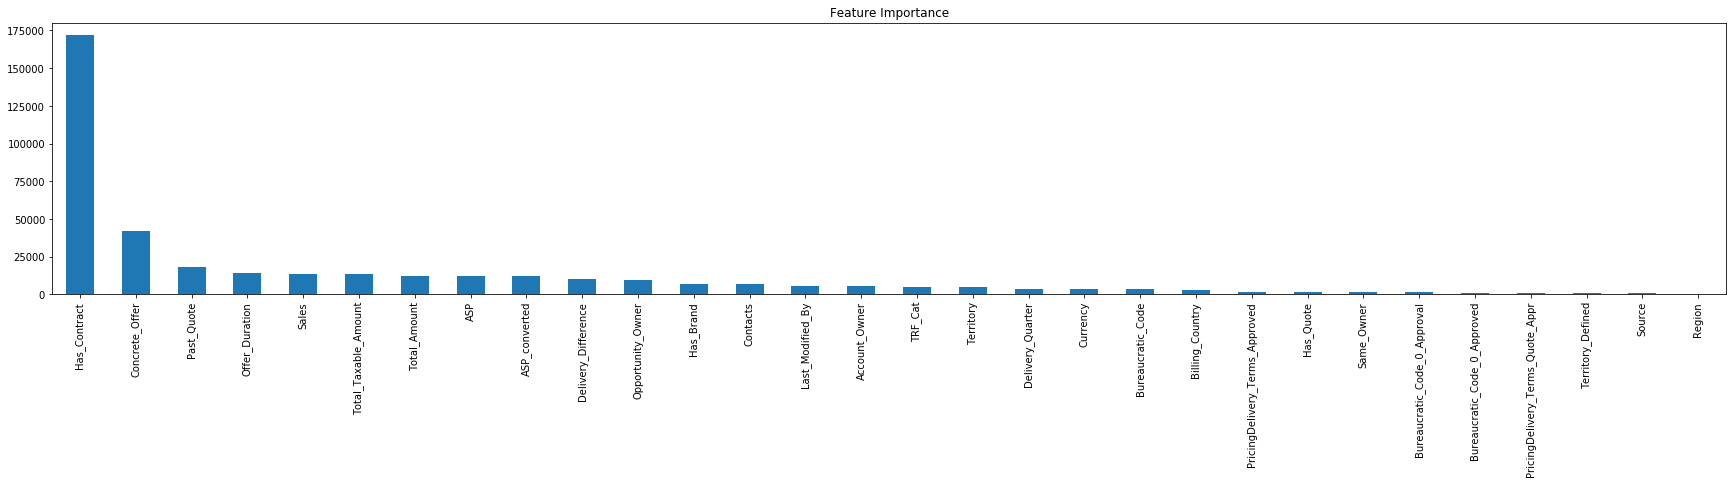

In [328]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model1.feature_importance("gain"), predictors).sort_values(ascending = False)
plt.rcParams['figure.figsize'] = 30, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [329]:
print feat_imp

Has_Contract                        171681.125832
Concrete_Offer                       41701.433119
Past_Quote                           18000.308433
Offer_Duration                       14422.037047
Sales                                13552.332833
Total_Taxable_Amount                 13259.214400
Total_Amount                         12276.022998
ASP                                  11944.744905
ASP_converted                        11909.603532
Delivery_Difference                   9938.956308
Opportunity_Owner                     9681.571574
Has_Brand                             7171.184687
Contacts                              6582.660927
Last_Modified_By                      5843.806670
Account_Owner                         5256.752464
TRF_Cat                               5026.317464
Territory                             4589.494391
Delivery_Quarter                      3647.937623
Currency                              3321.965148
Bureaucratic_Code                     3225.825877


In [330]:
y_pred = model1.predict(x_test.drop(target, axis=1))
pred = pd.DataFrame(y_pred, index = x_test.index, columns = ["Prediction"])
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()
log_loss(answer["Stage"], answer["Prediction"])

0.07314549862172955

In [17]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model1.predict(validation.drop(leak, axis = 1))

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
answer = validation.join(pred)

answer = pd.DataFrame(answer.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [18]:
prev = pd.read_csv("acceptable/submission_23.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9937971554691853

In [260]:
prev = pd.read_csv("acceptable/submission_11.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

-0.015596152866255718

In [160]:
answer.to_csv("ensemble0.csv", index = False, header = False)

In [162]:
xtradrop = ["Offer_Duration", "Has_Quote", "Territory_Defined"]
x_train, x_test, y_train, y_test = train_test_split(df.drop(xtradrop, axis = 1), df.Stage, test_size = 0.3, random_state = 123456789, stratify = df.Stage)
categorical = [x for x in df.drop(target + xtradrop, axis = 1).select_dtypes('category').columns if x != 'Stage'] + ["TRF_Cat"]
#categorical = [x for x in cat_vars if x in df.columns]
train_data = lgb.Dataset(data = x_train.drop(target, axis = 1), label = x_train.Stage, categorical_feature = categorical)
test_data =  lgb.Dataset(data = x_test.drop(target, axis = 1), label = x_test.Stage)

parameters = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 50,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.6,
    'bagging_freq': 30,
    'learning_rate': 0.015,
    'max_bin': 400,
    'verbose': 0
}

model2 = lgb.train(parameters, train_data, valid_sets = test_data, num_boost_round = 5000, early_stopping_rounds = 500)

[1]	valid_0's binary_logloss: 0.681754
Training until validation scores don't improve for 500 rounds
[2]	valid_0's binary_logloss: 0.67549
[3]	valid_0's binary_logloss: 0.663127
[4]	valid_0's binary_logloss: 0.651039
[5]	valid_0's binary_logloss: 0.63918
[6]	valid_0's binary_logloss: 0.635874
[7]	valid_0's binary_logloss: 0.624476
[8]	valid_0's binary_logloss: 0.613575
[9]	valid_0's binary_logloss: 0.608788
[10]	valid_0's binary_logloss: 0.598269
[11]	valid_0's binary_logloss: 0.592763
[12]	valid_0's binary_logloss: 0.587901
[13]	valid_0's binary_logloss: 0.583025
[14]	valid_0's binary_logloss: 0.573096
[15]	valid_0's binary_logloss: 0.568231
[16]	valid_0's binary_logloss: 0.563616
[17]	valid_0's binary_logloss: 0.559467
[18]	valid_0's binary_logloss: 0.556352
[19]	valid_0's binary_logloss: 0.547328
[20]	valid_0's binary_logloss: 0.54306
[21]	valid_0's binary_logloss: 0.539691
[22]	valid_0's binary_logloss: 0.530935
[23]	valid_0's binary_logloss: 0.522434
[24]	valid_0's binary_logloss:

[205]	valid_0's binary_logloss: 0.165282
[206]	valid_0's binary_logloss: 0.165025
[207]	valid_0's binary_logloss: 0.164766
[208]	valid_0's binary_logloss: 0.164491
[209]	valid_0's binary_logloss: 0.164285
[210]	valid_0's binary_logloss: 0.163954
[211]	valid_0's binary_logloss: 0.163672
[212]	valid_0's binary_logloss: 0.163408
[213]	valid_0's binary_logloss: 0.163268
[214]	valid_0's binary_logloss: 0.16201
[215]	valid_0's binary_logloss: 0.160787
[216]	valid_0's binary_logloss: 0.159479
[217]	valid_0's binary_logloss: 0.158357
[218]	valid_0's binary_logloss: 0.157168
[219]	valid_0's binary_logloss: 0.156993
[220]	valid_0's binary_logloss: 0.156859
[221]	valid_0's binary_logloss: 0.156613
[222]	valid_0's binary_logloss: 0.1564
[223]	valid_0's binary_logloss: 0.156178
[224]	valid_0's binary_logloss: 0.155073
[225]	valid_0's binary_logloss: 0.153939
[226]	valid_0's binary_logloss: 0.152744
[227]	valid_0's binary_logloss: 0.152574
[228]	valid_0's binary_logloss: 0.15152
[229]	valid_0's bina

[405]	valid_0's binary_logloss: 0.0972045
[406]	valid_0's binary_logloss: 0.097001
[407]	valid_0's binary_logloss: 0.096715
[408]	valid_0's binary_logloss: 0.0966555
[409]	valid_0's binary_logloss: 0.0963803
[410]	valid_0's binary_logloss: 0.0963188
[411]	valid_0's binary_logloss: 0.0962523
[412]	valid_0's binary_logloss: 0.0961985
[413]	valid_0's binary_logloss: 0.0961293
[414]	valid_0's binary_logloss: 0.0960596
[415]	valid_0's binary_logloss: 0.0959876
[416]	valid_0's binary_logloss: 0.0956791
[417]	valid_0's binary_logloss: 0.0956139
[418]	valid_0's binary_logloss: 0.0955662
[419]	valid_0's binary_logloss: 0.0954932
[420]	valid_0's binary_logloss: 0.0954076
[421]	valid_0's binary_logloss: 0.0953238
[422]	valid_0's binary_logloss: 0.095309
[423]	valid_0's binary_logloss: 0.0950066
[424]	valid_0's binary_logloss: 0.0949481
[425]	valid_0's binary_logloss: 0.09488
[426]	valid_0's binary_logloss: 0.0948241
[427]	valid_0's binary_logloss: 0.0947532
[428]	valid_0's binary_logloss: 0.09471

[634]	valid_0's binary_logloss: 0.0792665
[635]	valid_0's binary_logloss: 0.0792404
[636]	valid_0's binary_logloss: 0.0792072
[637]	valid_0's binary_logloss: 0.0791663
[638]	valid_0's binary_logloss: 0.0791307
[639]	valid_0's binary_logloss: 0.079073
[640]	valid_0's binary_logloss: 0.0790172
[641]	valid_0's binary_logloss: 0.0789391
[642]	valid_0's binary_logloss: 0.0789056
[643]	valid_0's binary_logloss: 0.0788792
[644]	valid_0's binary_logloss: 0.0788734
[645]	valid_0's binary_logloss: 0.0788625
[646]	valid_0's binary_logloss: 0.0788198
[647]	valid_0's binary_logloss: 0.0787613
[648]	valid_0's binary_logloss: 0.0787101
[649]	valid_0's binary_logloss: 0.0787056
[650]	valid_0's binary_logloss: 0.078697
[651]	valid_0's binary_logloss: 0.07863
[652]	valid_0's binary_logloss: 0.0786033
[653]	valid_0's binary_logloss: 0.078542
[654]	valid_0's binary_logloss: 0.0784874
[655]	valid_0's binary_logloss: 0.0784664
[656]	valid_0's binary_logloss: 0.0784221
[657]	valid_0's binary_logloss: 0.07840

[836]	valid_0's binary_logloss: 0.076411
[837]	valid_0's binary_logloss: 0.0763859
[838]	valid_0's binary_logloss: 0.0763832
[839]	valid_0's binary_logloss: 0.0764083
[840]	valid_0's binary_logloss: 0.0764168
[841]	valid_0's binary_logloss: 0.0764364
[842]	valid_0's binary_logloss: 0.0764238
[843]	valid_0's binary_logloss: 0.0764158
[844]	valid_0's binary_logloss: 0.0764427
[845]	valid_0's binary_logloss: 0.0764201
[846]	valid_0's binary_logloss: 0.0763866
[847]	valid_0's binary_logloss: 0.0764462
[848]	valid_0's binary_logloss: 0.0764662
[849]	valid_0's binary_logloss: 0.0764838
[850]	valid_0's binary_logloss: 0.0764659
[851]	valid_0's binary_logloss: 0.076518
[852]	valid_0's binary_logloss: 0.0765107
[853]	valid_0's binary_logloss: 0.0765171
[854]	valid_0's binary_logloss: 0.076519
[855]	valid_0's binary_logloss: 0.0765208
[856]	valid_0's binary_logloss: 0.0765391
[857]	valid_0's binary_logloss: 0.0765244
[858]	valid_0's binary_logloss: 0.0765483
[859]	valid_0's binary_logloss: 0.076

[1047]	valid_0's binary_logloss: 0.0784025
[1048]	valid_0's binary_logloss: 0.0784401
[1049]	valid_0's binary_logloss: 0.0784611
[1050]	valid_0's binary_logloss: 0.0784867
[1051]	valid_0's binary_logloss: 0.0785783
[1052]	valid_0's binary_logloss: 0.0786172
[1053]	valid_0's binary_logloss: 0.0786443
[1054]	valid_0's binary_logloss: 0.0787131
[1055]	valid_0's binary_logloss: 0.0787118
[1056]	valid_0's binary_logloss: 0.0787713
[1057]	valid_0's binary_logloss: 0.078757
[1058]	valid_0's binary_logloss: 0.0788061
[1059]	valid_0's binary_logloss: 0.0787792
[1060]	valid_0's binary_logloss: 0.0787953
[1061]	valid_0's binary_logloss: 0.0788008
[1062]	valid_0's binary_logloss: 0.0788206
[1063]	valid_0's binary_logloss: 0.0788337
[1064]	valid_0's binary_logloss: 0.0787923
[1065]	valid_0's binary_logloss: 0.0788235
[1066]	valid_0's binary_logloss: 0.078856
[1067]	valid_0's binary_logloss: 0.0788405
[1068]	valid_0's binary_logloss: 0.0788962
[1069]	valid_0's binary_logloss: 0.078917
[1070]	valid_0

[1239]	valid_0's binary_logloss: 0.0818455
[1240]	valid_0's binary_logloss: 0.0819074
[1241]	valid_0's binary_logloss: 0.0819119
[1242]	valid_0's binary_logloss: 0.081987
[1243]	valid_0's binary_logloss: 0.0820616
[1244]	valid_0's binary_logloss: 0.0820784
[1245]	valid_0's binary_logloss: 0.0821188
[1246]	valid_0's binary_logloss: 0.0821005
[1247]	valid_0's binary_logloss: 0.0820953
[1248]	valid_0's binary_logloss: 0.082134
[1249]	valid_0's binary_logloss: 0.0821271
[1250]	valid_0's binary_logloss: 0.0820955
[1251]	valid_0's binary_logloss: 0.0820828
[1252]	valid_0's binary_logloss: 0.0821462
[1253]	valid_0's binary_logloss: 0.0821713
[1254]	valid_0's binary_logloss: 0.0822487
[1255]	valid_0's binary_logloss: 0.0822667
[1256]	valid_0's binary_logloss: 0.0822941
[1257]	valid_0's binary_logloss: 0.082341
[1258]	valid_0's binary_logloss: 0.0824129
[1259]	valid_0's binary_logloss: 0.082497
[1260]	valid_0's binary_logloss: 0.0825163
[1261]	valid_0's binary_logloss: 0.0825149
[1262]	valid_0'

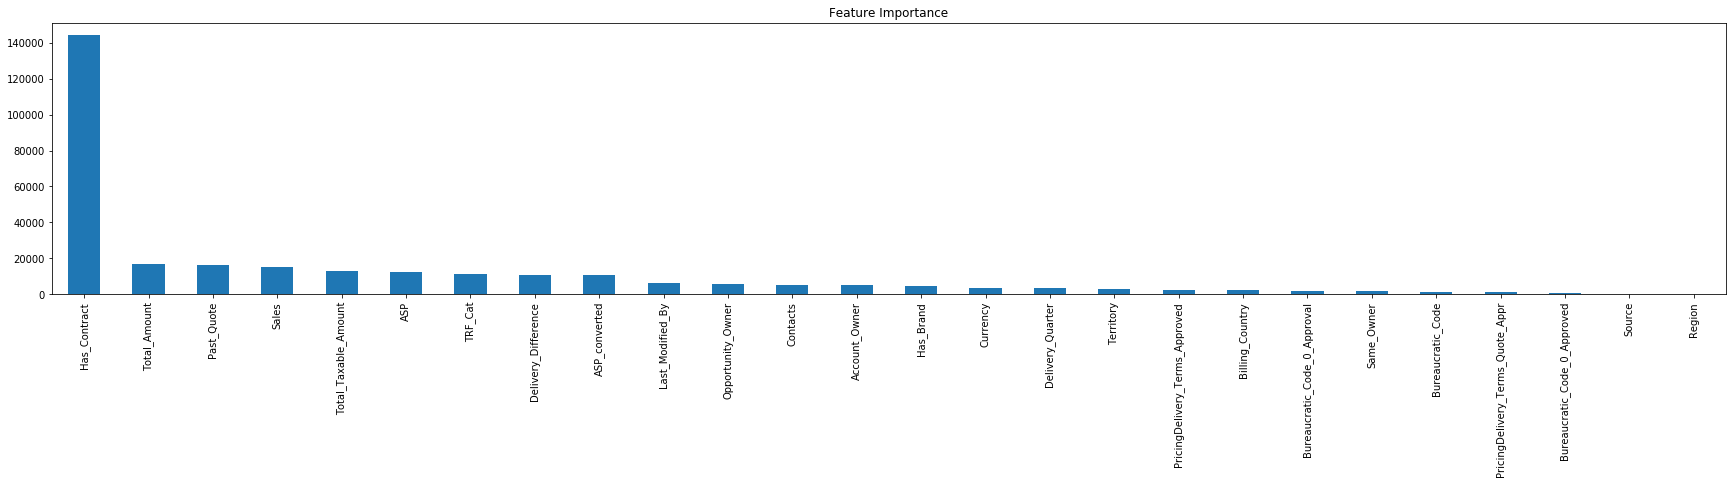

In [163]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model2.feature_importance("gain"), predictors).sort_values(ascending = False)
plt.rcParams['figure.figsize'] = 30, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [164]:
print feat_imp

Has_Contract                        144022.143502
Total_Amount                         16869.601470
Past_Quote                           16150.863852
Sales                                14960.023335
Total_Taxable_Amount                 12790.201369
ASP                                  12155.831620
TRF_Cat                              11059.830809
Delivery_Difference                  10890.157604
ASP_converted                        10870.116268
Last_Modified_By                      6341.125548
Opportunity_Owner                     5970.740688
Contacts                              5136.977652
Account_Owner                         4993.701614
Has_Brand                             4720.181343
Currency                              3565.535498
Delivery_Quarter                      3527.227629
Territory                             3111.163603
PricingDelivery_Terms_Approved        2221.060023
Billing_Country                       2166.071383
Bureaucratic_Code_0_Approval          1941.883765


In [165]:
y_pred = model2.predict(x_test.drop(target, axis=1))
pred = pd.DataFrame(y_pred, index = x_test.index, columns = ["Prediction"])
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()
log_loss(answer["Stage"], answer["Prediction"])

0.08171109219197839

In [166]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model2.predict(validation.drop(leak + xtradrop, axis = 1))

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
answer2 = validation.join(pred)

answer2 = pd.DataFrame(answer2.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [167]:
prev = pd.read_csv("acceptable/submission_23.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer2["Prediction"])

0.9900982403298886

In [168]:
prev = pd.read_csv("acceptable/submission_11.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer2["Prediction"])

0.9943710706096234

In [73]:
ens = pd.read_csv("ensemble1.csv", names=["Opportunity_ID", "Prediction"])
ens["Prediction"].corr(answer2["Prediction"])

0.9963255769359656

In [169]:
answer2.to_csv("ensemble1.csv", index = False, header = False)

In [161]:
xtradrop = ["Sales", "Total_Taxable_Amount", "Territory_Defined"]
x_train, x_test, y_train, y_test = train_test_split(df.drop(xtradrop, axis = 1), df.Stage, test_size = 0.3, random_state = 534, stratify = df.Stage)
categorical = [x for x in df.drop(target + xtradrop, axis = 1).select_dtypes('category').columns if x != 'Stage'] + ["TRF_Cat"]
#categorical = [x for x in cat_vars if x in df.columns]
train_data = lgb.Dataset(data = x_train.drop(target, axis = 1), label = x_train.Stage, categorical_feature = categorical)
test_data =  lgb.Dataset(data = x_test.drop(target, axis = 1), label = x_test.Stage)

parameters = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 50,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.6,
    'bagging_freq': 30,
    'learning_rate': 0.015,
    'max_bin': 400,
    'verbose': 0
}

model3 = lgb.train(parameters, train_data, valid_sets = test_data, num_boost_round = 5000, early_stopping_rounds = 500)

[1]	valid_0's binary_logloss: 0.675195
Training until validation scores don't improve for 500 rounds
[2]	valid_0's binary_logloss: 0.668753
[3]	valid_0's binary_logloss: 0.662399
[4]	valid_0's binary_logloss: 0.650511
[5]	valid_0's binary_logloss: 0.644128
[6]	valid_0's binary_logloss: 0.640657
[7]	valid_0's binary_logloss: 0.634872
[8]	valid_0's binary_logloss: 0.623918
[9]	valid_0's binary_logloss: 0.613099
[10]	valid_0's binary_logloss: 0.607658
[11]	valid_0's binary_logloss: 0.597185
[12]	valid_0's binary_logloss: 0.593696
[13]	valid_0's binary_logloss: 0.583796
[14]	valid_0's binary_logloss: 0.57899
[15]	valid_0's binary_logloss: 0.574642
[16]	valid_0's binary_logloss: 0.569889
[17]	valid_0's binary_logloss: 0.5653
[18]	valid_0's binary_logloss: 0.561632
[19]	valid_0's binary_logloss: 0.552713
[20]	valid_0's binary_logloss: 0.543668
[21]	valid_0's binary_logloss: 0.539981
[22]	valid_0's binary_logloss: 0.531451
[23]	valid_0's binary_logloss: 0.527684
[24]	valid_0's binary_logloss:

[205]	valid_0's binary_logloss: 0.166076
[206]	valid_0's binary_logloss: 0.165852
[207]	valid_0's binary_logloss: 0.165609
[208]	valid_0's binary_logloss: 0.165378
[209]	valid_0's binary_logloss: 0.164168
[210]	valid_0's binary_logloss: 0.163895
[211]	valid_0's binary_logloss: 0.162654
[212]	valid_0's binary_logloss: 0.161454
[213]	valid_0's binary_logloss: 0.160295
[214]	valid_0's binary_logloss: 0.159191
[215]	valid_0's binary_logloss: 0.158932
[216]	valid_0's binary_logloss: 0.158579
[217]	valid_0's binary_logloss: 0.158374
[218]	valid_0's binary_logloss: 0.158163
[219]	valid_0's binary_logloss: 0.157915
[220]	valid_0's binary_logloss: 0.156837
[221]	valid_0's binary_logloss: 0.156628
[222]	valid_0's binary_logloss: 0.156405
[223]	valid_0's binary_logloss: 0.15621
[224]	valid_0's binary_logloss: 0.155961
[225]	valid_0's binary_logloss: 0.155726
[226]	valid_0's binary_logloss: 0.155436
[227]	valid_0's binary_logloss: 0.155206
[228]	valid_0's binary_logloss: 0.15497
[229]	valid_0's bi

[415]	valid_0's binary_logloss: 0.103902
[416]	valid_0's binary_logloss: 0.103869
[417]	valid_0's binary_logloss: 0.103797
[418]	valid_0's binary_logloss: 0.103504
[419]	valid_0's binary_logloss: 0.103211
[420]	valid_0's binary_logloss: 0.102925
[421]	valid_0's binary_logloss: 0.102863
[422]	valid_0's binary_logloss: 0.102593
[423]	valid_0's binary_logloss: 0.10253
[424]	valid_0's binary_logloss: 0.102227
[425]	valid_0's binary_logloss: 0.102156
[426]	valid_0's binary_logloss: 0.102114
[427]	valid_0's binary_logloss: 0.102069
[428]	valid_0's binary_logloss: 0.101778
[429]	valid_0's binary_logloss: 0.10152
[430]	valid_0's binary_logloss: 0.101475
[431]	valid_0's binary_logloss: 0.101231
[432]	valid_0's binary_logloss: 0.101172
[433]	valid_0's binary_logloss: 0.101105
[434]	valid_0's binary_logloss: 0.101096
[435]	valid_0's binary_logloss: 0.10084
[436]	valid_0's binary_logloss: 0.100653
[437]	valid_0's binary_logloss: 0.100388
[438]	valid_0's binary_logloss: 0.100162
[439]	valid_0's bin

[624]	valid_0's binary_logloss: 0.0870406
[625]	valid_0's binary_logloss: 0.0870012
[626]	valid_0's binary_logloss: 0.0870004
[627]	valid_0's binary_logloss: 0.0868837
[628]	valid_0's binary_logloss: 0.0868203
[629]	valid_0's binary_logloss: 0.0867186
[630]	valid_0's binary_logloss: 0.0866125
[631]	valid_0's binary_logloss: 0.0865431
[632]	valid_0's binary_logloss: 0.0865103
[633]	valid_0's binary_logloss: 0.0864478
[634]	valid_0's binary_logloss: 0.0864085
[635]	valid_0's binary_logloss: 0.0864422
[636]	valid_0's binary_logloss: 0.0864169
[637]	valid_0's binary_logloss: 0.0863774
[638]	valid_0's binary_logloss: 0.0863295
[639]	valid_0's binary_logloss: 0.0862573
[640]	valid_0's binary_logloss: 0.0862422
[641]	valid_0's binary_logloss: 0.0861899
[642]	valid_0's binary_logloss: 0.0861401
[643]	valid_0's binary_logloss: 0.0860878
[644]	valid_0's binary_logloss: 0.0859999
[645]	valid_0's binary_logloss: 0.0859885
[646]	valid_0's binary_logloss: 0.0859664
[647]	valid_0's binary_logloss: 0.

[836]	valid_0's binary_logloss: 0.0831196
[837]	valid_0's binary_logloss: 0.0831339
[838]	valid_0's binary_logloss: 0.0831612
[839]	valid_0's binary_logloss: 0.0831676
[840]	valid_0's binary_logloss: 0.0831362
[841]	valid_0's binary_logloss: 0.0831315
[842]	valid_0's binary_logloss: 0.0831428
[843]	valid_0's binary_logloss: 0.0830925
[844]	valid_0's binary_logloss: 0.0831177
[845]	valid_0's binary_logloss: 0.0831121
[846]	valid_0's binary_logloss: 0.0831337
[847]	valid_0's binary_logloss: 0.083127
[848]	valid_0's binary_logloss: 0.0831043
[849]	valid_0's binary_logloss: 0.0831604
[850]	valid_0's binary_logloss: 0.0831538
[851]	valid_0's binary_logloss: 0.0831612
[852]	valid_0's binary_logloss: 0.0831208
[853]	valid_0's binary_logloss: 0.0831077
[854]	valid_0's binary_logloss: 0.0830746
[855]	valid_0's binary_logloss: 0.0830755
[856]	valid_0's binary_logloss: 0.083097
[857]	valid_0's binary_logloss: 0.0830983
[858]	valid_0's binary_logloss: 0.0831252
[859]	valid_0's binary_logloss: 0.08

[1049]	valid_0's binary_logloss: 0.0850959
[1050]	valid_0's binary_logloss: 0.0851573
[1051]	valid_0's binary_logloss: 0.0852381
[1052]	valid_0's binary_logloss: 0.085272
[1053]	valid_0's binary_logloss: 0.0853308
[1054]	valid_0's binary_logloss: 0.085346
[1055]	valid_0's binary_logloss: 0.08541
[1056]	valid_0's binary_logloss: 0.0854391
[1057]	valid_0's binary_logloss: 0.0854785
[1058]	valid_0's binary_logloss: 0.0854802
[1059]	valid_0's binary_logloss: 0.0855082
[1060]	valid_0's binary_logloss: 0.0855269
[1061]	valid_0's binary_logloss: 0.0855571
[1062]	valid_0's binary_logloss: 0.0855575
[1063]	valid_0's binary_logloss: 0.0856274
[1064]	valid_0's binary_logloss: 0.0856586
[1065]	valid_0's binary_logloss: 0.0857134
[1066]	valid_0's binary_logloss: 0.0857561
[1067]	valid_0's binary_logloss: 0.085753
[1068]	valid_0's binary_logloss: 0.0857717
[1069]	valid_0's binary_logloss: 0.0858318
[1070]	valid_0's binary_logloss: 0.0859008
[1071]	valid_0's binary_logloss: 0.0859677
[1072]	valid_0's

[1250]	valid_0's binary_logloss: 0.0891036
[1251]	valid_0's binary_logloss: 0.0891244
[1252]	valid_0's binary_logloss: 0.0891089
[1253]	valid_0's binary_logloss: 0.0891199
[1254]	valid_0's binary_logloss: 0.0892085
[1255]	valid_0's binary_logloss: 0.089228
[1256]	valid_0's binary_logloss: 0.0893297
[1257]	valid_0's binary_logloss: 0.0893188
[1258]	valid_0's binary_logloss: 0.0893944
[1259]	valid_0's binary_logloss: 0.0893847
[1260]	valid_0's binary_logloss: 0.0893775
[1261]	valid_0's binary_logloss: 0.0894184
[1262]	valid_0's binary_logloss: 0.0893735
[1263]	valid_0's binary_logloss: 0.0894233
[1264]	valid_0's binary_logloss: 0.0894076
[1265]	valid_0's binary_logloss: 0.0894745
[1266]	valid_0's binary_logloss: 0.0895271
[1267]	valid_0's binary_logloss: 0.0895259
[1268]	valid_0's binary_logloss: 0.089534
[1269]	valid_0's binary_logloss: 0.0894956
[1270]	valid_0's binary_logloss: 0.0895233
[1271]	valid_0's binary_logloss: 0.0895219
[1272]	valid_0's binary_logloss: 0.0895569
[1273]	valid_

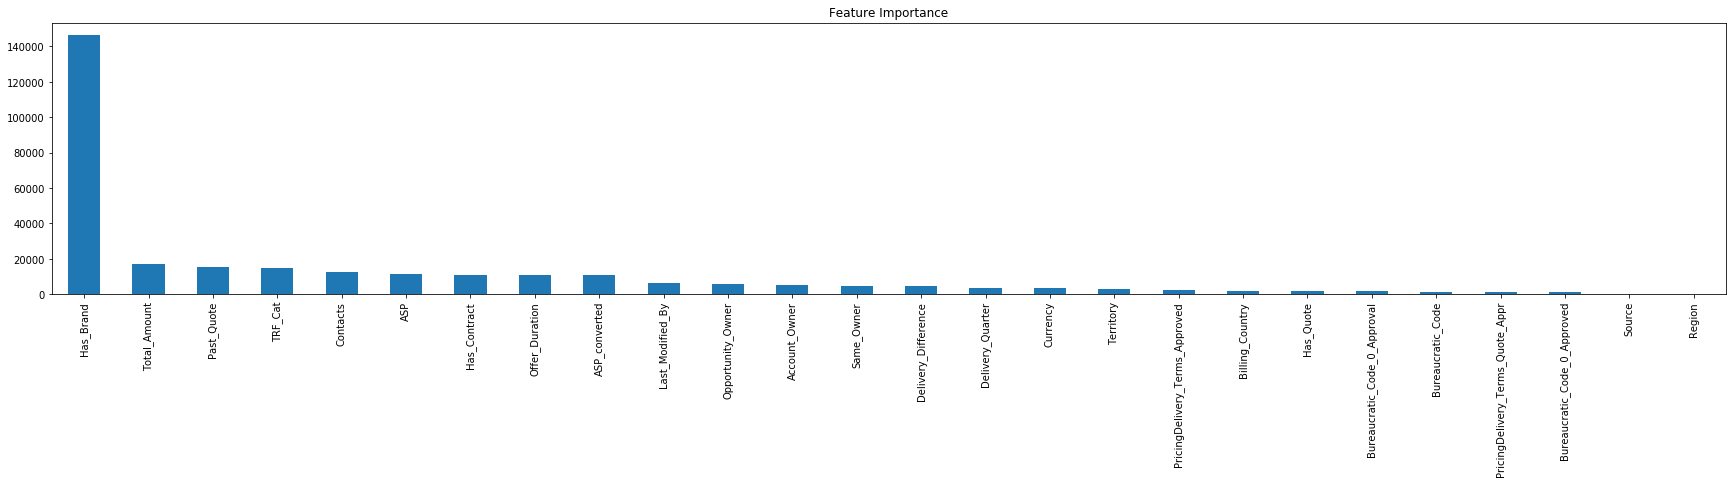

In [76]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model2.feature_importance("gain"), predictors).sort_values(ascending = False)
plt.rcParams['figure.figsize'] = 30, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [57]:
print feat_imp

Has_Contract                        171681.125832
Concrete_Offer                       41701.433119
Past_Quote                           18000.308433
Offer_Duration                       14422.037047
Sales                                13552.332833
Total_Taxable_Amount                 13259.214400
Total_Amount                         12276.022998
ASP                                  11944.744905
ASP_converted                        11909.603532
Delivery_Difference                   9938.956308
Opportunity_Owner                     9681.571574
Has_Brand                             7171.184687
Contacts                              6582.660927
Last_Modified_By                      5843.806670
Account_Owner                         5256.752464
TRF_Cat                               5026.317464
Territory                             4589.494391
Delivery_Quarter                      3647.937623
Currency                              3321.965148
Bureaucratic_Code                     3225.825877


In [79]:
y_pred = model3.predict(x_test.drop(target, axis=1))
pred = pd.DataFrame(y_pred, index = x_test.index, columns = ["Prediction"])
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()
log_loss(answer["Stage"], answer["Prediction"])

0.07577009118676456

In [82]:
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model3.predict(validation.drop(leak + xtradrop, axis = 1))

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
answer3 = validation.join(pred)

answer3 = pd.DataFrame(answer3.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [83]:
prev = pd.read_csv("acceptable/submission_23.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer3["Prediction"])

0.9859850430706056

In [84]:
prev = pd.read_csv("acceptable/submission_11.csv")
prev["Prediction"].corr(answer3["Prediction"])

0.9882098943559193

In [85]:
ens = pd.read_csv("ensemble1.csv", names=["Opportunity_ID", "Prediction"])
ens["Prediction"].corr(answer3["Prediction"])

0.9935473735308186

In [87]:
ens = pd.read_csv("ensemble2.csv", names=["Opportunity_ID", "Prediction"])
ens["Prediction"].corr(answer3["Prediction"])

0.9919253680015422

In [89]:
answer2.to_csv("ensemble3.csv", index = False, header = False)

In [188]:
ens_list = []
ens_list.append(pd.read_csv("acceptable/submission_11.csv", names=["Opportunity_ID", "Prediction"]))
ens_list.append(pd.read_csv("acceptable/submission_23.csv", names=["Opportunity_ID", "Prediction"]))
ens_list.append(pd.read_csv("acceptable/submission_24.csv", names=["Opportunity_ID", "Prediction"]))
ens_list.append(pd.read_csv("acceptable/submission_25.csv", names=["Opportunity_ID", "Prediction"]))
ens_list.append(pd.read_csv("acceptable/submission_26.csv", names=["Opportunity_ID", "Prediction"]))
ens_list.append(pd.read_csv("ensemble0.csv", names=["Opportunity_ID", "Prediction"]))
ens_list.append(pd.read_csv("ensemble1.csv", names=["Opportunity_ID", "Prediction"]))
#ens_list.append(pd.read_csv("ensemble3.csv", names=["Opportunity_ID", "Prediction"]))

In [171]:
final = ens_list[0].copy()
N = len(ens_list)

for i in range(1,N):
    aux = final.merge(ens_list[i], on = "Opportunity_ID")    
    aux["Prediction"] = aux["Prediction_x"] + aux["Prediction_y"]
    final["Prediction"] = aux["Prediction"]

final["Prediction"] = final["Prediction"] / (N + .0)

In [189]:
aux = ens_list[0].merge(ens_list[4], on = "Opportunity_ID")    
aux["Prediction"] = 0.5 * aux["Prediction_x"] + 0.5 * aux["Prediction_y"]

0.9983067591123109

In [190]:
aux["Prediction"].corr(ens_list[1]["Prediction"])

0.9959126303080376

In [174]:
avg = pd.read_csv("acceptable/submission_11_23.csv", names=["Opportunity_ID", "Prediction"])

In [175]:
final["Prediction"].corr(avg["Prediction"])

0.9989846931346945

In [193]:
aux.drop(["Prediction_x", "Prediction_y"], axis = 1).to_csv("submisson_ensamble_3.csv", index = False, header = False)

In [180]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 5, random_state = 0)
kf.get_n_splits(df) # returns the number of splitting iterations in the cross-validator
print(kf) 

KFold(n_splits=5, random_state=0, shuffle=False)


In [186]:
from sklearn.model_selection import LeaveOneOut 
loo = LeaveOneOut()
loo.get_n_splits(kf)

TypeError: Expected sequence or array-like, got <class 'sklearn.model_selection._split.KFold'>

In [23]:
pred1 = pd.read_csv("acceptable/submission_11.csv", names=["Opportunity_ID", "Prediction"])
pred2 = pd.read_csv("acceptable/submission_26.csv", names=["Opportunity_ID", "Prediction"])
aux = pred1.merge(pred2, on = "Opportunity_ID")    
aux["Prediction"] = aux["Prediction_x"] + aux["Prediction_y"]
aux = aux.drop(["Prediction_x", "Prediction_y"], axis = 1)
aux = aux.merge(answer, on = "Opportunity_ID")
aux["Prediction"] = aux["Prediction_x"] + aux["Prediction_y"]
aux = aux.drop(["Prediction_x", "Prediction_y"], axis = 1)

,Opportunity_ID,Prediction
0,10689,2.993964
1,10690,2.982943
2,10691,2.867958
3,10692,2.685251
4,10693,2.929961
5,10694,2.939125
6,10695,0.015438
7,10696,0.011470
8,10697,0.037827
9,10698,0.007708


In [25]:
aux.to_csv("submisson_ensamble_5.csv", index = False, header = False)

In [24]:
aux["Prediction"] = aux["Prediction"] / 3.0

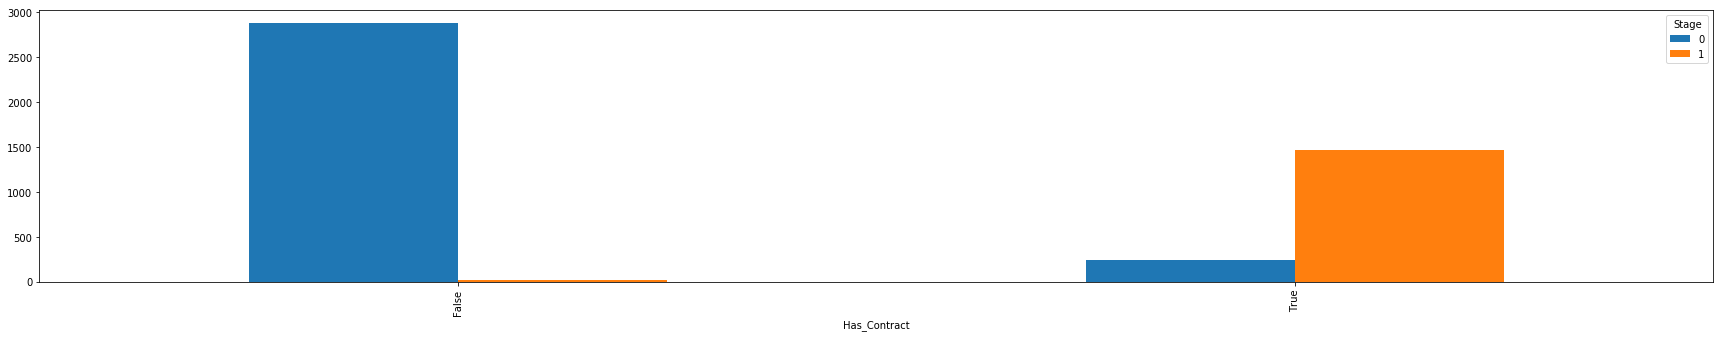

In [36]:
pd.crosstab(df[df.Offer_Duration.isna()].Has_Contract, df[df.Offer_Duration.isna()].Stage).plot(kind = "bar")

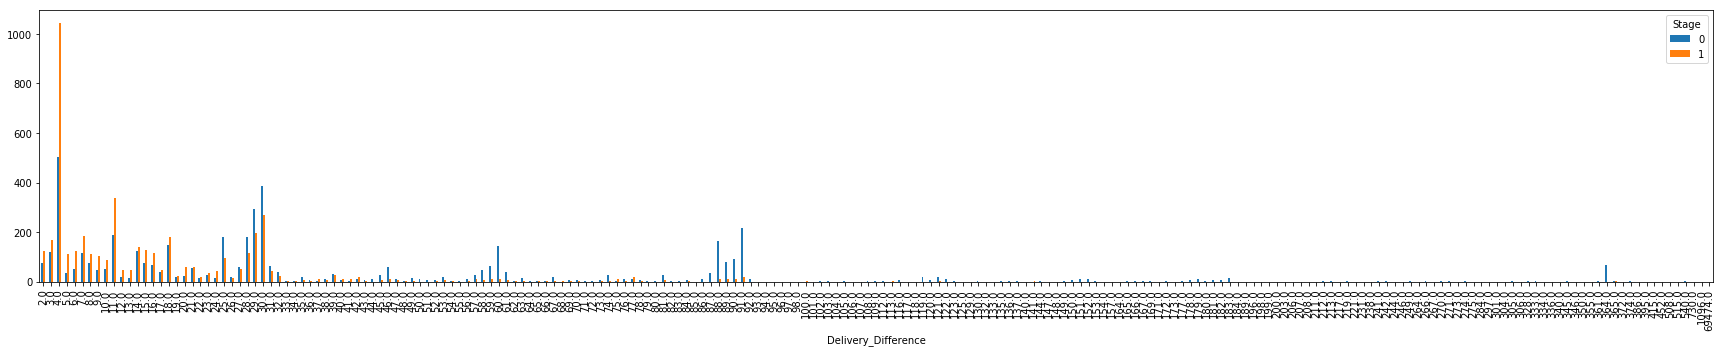

In [34]:
pd.crosstab(df[df.Delivery_Difference > 1].Delivery_Difference, df[df.Delivery_Difference > 1].Stage).plot(kind = "bar")

In [250]:
from sklearn.preprocessing import StandardScaler

def logreg_preprocess(df):

    #save = ["Currency", "Bureaucratic_Code", "Billing_Country", "PricingDelivery_Terms_Approved", "Has_Quote",
    #       "Same_Owner", "Bureaucratic_Code_0_Approval", "Bureaucratic_Code_0_Approved", 
    #        "PricingDelivery_Terms_Quote_Appr", "Territory_Defined", "Source", "Region"]
    
    save = ["Bureaucratic_Code_0_Approval","Bureaucratic_Code_0_Approved", "PricingDelivery_Terms_Quote_Appr", 
            "Territory_Defined", "Source", "Territory"]    
    
    data = df.drop(save, axis = 1).copy()
    
    cat_vars = [x for x in data.select_dtypes('category').columns if x != "Stage" and x not in save]
    cat_list = []
    for var in cat_vars:
        cat_list += [pd.get_dummies(data[var], prefix = var)]       

    data.loc[data.Delivery_Difference.isna(), "Delivery_Difference"] = 20
    data.loc[data.Total_Amount.isna(), "Total_Amount"] = data.Total_Amount.mean()
    data.loc[data.Total_Amount.isna(), "Total_Taxable_Amount"] = data.Total_Taxable_Amount.mean()
        
    has_nulls = ["Concrete_Offer", "Offer_Duration", "Past_Quote"]
    
    data = data.drop(cat_vars + has_nulls, axis = 1)
    data = data.drop(data[data.ASP.isna()].index)
    
    bool_vars = [x for x in data.select_dtypes('bool').columns] + ["Stage", "Opportunity_ID"]
    num_vars = [x for x in data.columns if x not in bool_vars]
    
    bool_data = data[bool_vars]
    num_data = data[num_vars]
        
    scaler = StandardScaler()
    scaler_data = pd.DataFrame(scaler.fit_transform(num_data), index = num_data.index, columns = num_vars)

    data = bool_data.join(scaler_data)
    
    for c in cat_list:
        data = data.join(c)
    
    return (data)


from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logregdf = logreg_preprocess(df)

In [251]:
X_tr, X_te, y_tr, y_te = train_test_split(logregdf.drop(["Opportunity_ID", "Stage"], axis = 1), logregdf.Stage, test_size = 0.3, random_state = 0, stratify = logregdf.Stage)
logreg = LogisticRegression().set_params(penalty = 'l2', max_iter = 5000, verbose = 1)
logreg.fit(X_tr, y_tr)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=1, warm_start=False)

In [266]:
y_pred = logreg.predict_proba(X_te)[:,1]
log_loss(y_te, y_pred)

0.11430692694327692

In [318]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
gnb = GaussianNB()

nbdf = df.drop(["Concrete_Offer"], axis = 1).copy()
#transform_vars = [x for x in nbdf.select_dtypes('category').columns if x != "Stage"] + [x for x in nbdf.select_dtypes('bool').columns if x != "Stage"]
nbdf = nbdf.apply(LabelEncoder().fit_transform)
#nbdf.drop(transform_vars, axis = 1, inplace = True)
#nbdf.loc[nbdf.Delivery_Difference.isna(), "Delivery_Difference"] = 20
#nbdf.loc[nbdf.Total_Amount.isna(), "Total_Amount"] = nbdf.Total_Amount.mean()
#nbdf.loc[nbdf.Total_Amount.isna(), "Total_Taxable_Amount"] = nbdf.Total_Taxable_Amount.mean()
#nbdf = nbdf.drop(nbdf[nbdf.ASP.isna()].index)

#has_nulls = ["Concrete_Offer", "Offer_Duration", "Past_Quote"]
    
#nbdf.drop(has_nulls, axis = 1, inplace = True)

#nbdf = nbdf.join(nn)

nbdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16883 entries, 0 to 16946
Data columns (total 32 columns):
Region                              16883 non-null int64
Territory                           16883 non-null int64
PricingDelivery_Terms_Quote_Appr    16883 non-null int64
PricingDelivery_Terms_Approved      16883 non-null int64
Bureaucratic_Code_0_Approval        16883 non-null int64
Bureaucratic_Code_0_Approved        16883 non-null int64
Bureaucratic_Code                   16883 non-null int64
Source                              16883 non-null int64
Billing_Country                     16883 non-null int64
Opportunity_ID                      16883 non-null int64
Sales_Contract_No                   16883 non-null int64
Account_Owner                       16883 non-null int64
Opportunity_Owner                   16883 non-null int64
Currency                            16883 non-null int64
Last_Modified_By                    16883 non-null int64
ASP                                 

In [319]:
X_train, X_test, y_train, y_test = train_test_split(nbdf.drop(target, axis = 1), nbdf.Stage, test_size = 0.3, random_state = 0, stratify = nbdf.Stage)
gnb.fit(X_train, y_train)
y_pred = gnb.predict_proba(X_test)[:,1]

In [320]:
log_loss(y_test, y_pred)

0.6013719461777741

In [321]:
y_pred

array([9.99999992e-01, 9.99984072e-01, 1.53345973e-07, ...,
       1.11521964e-10, 9.99998389e-01, 9.99999832e-01])

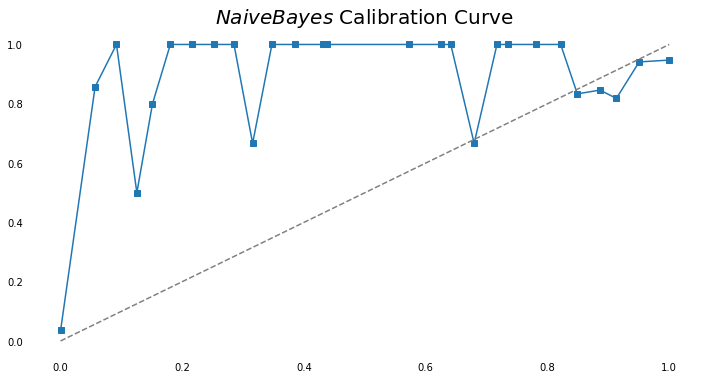

In [322]:
from sklearn.calibration import calibration_curve
import seaborn as sns
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred, n_bins = 30)

pltt = plt.pyplot
fig, ax = pltt.subplots(1, figsize = (12, 6))
pltt.plot(mean_predicted_value, fraction_of_positives, 's-')
pltt.plot([0, 1], [0, 1], '--', color = 'gray')

sns.despine(left = True, bottom = True)
pltt.gca().xaxis.set_ticks_position('none')
pltt.gca().yaxis.set_ticks_position('none')
pltt.title("$NaiveBayes$ Calibration Curve", fontsize = 20); pass

In [324]:
pred1 = pd.read_csv("acceptable/submission_11.csv", names=["Opportunity_ID", "Prediction"])
pred2 = pd.read_csv("acceptable/submission_23.csv", names=["Opportunity_ID", "Prediction"])
pred3 = pd.read_csv("acceptable/submission_28.csv", names=["Opportunity_ID", "Prediction"])
aux = pred1.merge(pred2, on = "Opportunity_ID")    
aux["Prediction"] = aux["Prediction_x"] + aux["Prediction_y"]
aux = aux.drop(["Prediction_x", "Prediction_y"], axis = 1)
aux = aux.merge(pred3, on = "Opportunity_ID")
aux["Prediction"] = aux["Prediction_x"] + aux["Prediction_y"]
aux = aux.drop(["Prediction_x", "Prediction_y"], axis = 1)
aux["Prediction"] = aux["Prediction"] / 3.0
aux

,Opportunity_ID,Prediction
0,10689,0.998509
1,10690,0.994992
2,10691,0.986180
3,10692,0.959986
4,10693,0.960721
5,10694,0.960362
6,10695,0.012547
7,10696,0.014328
8,10697,0.039496
9,10698,0.007068


In [325]:
aux.to_csv("submisson_ensamble_6.csv", index = False, header = False)